In [18]:
%load_ext autoreload
%autoreload 2

from src.models.gps import GPS
from src.models.gcn import GCN
from src.models.explainer.explainer_pipeline import ExplainerPipeline
from src.models.explainer.gnn_explainer import GNNExplainer
from src.data import loader

import networkx as nx

from torch_geometric.explain import ModelConfig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The node_mask and edge_mask attributes filter out nodes and edges belonging to motifs.

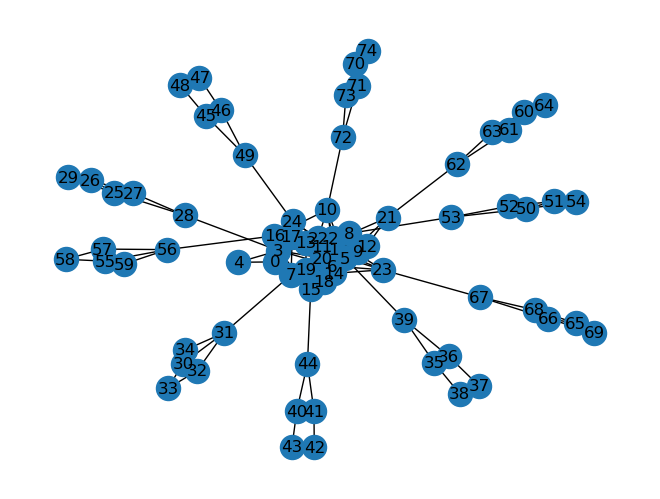

In [19]:
data, num_classes, data_networkx = loader.load_clean_bashapes(num_nodes=25, num_edges=5, num_motifs=10, laplacian_eigenvector_dimensions=2)
nx.draw(data_networkx, with_labels=True)

In [20]:
gps_params = {
    'pe_channels': 2,
    'num_layers': 4,
    'hidden_channels': 4,
    'num_attention_heads': 1,
    'observe_attention': True
}

gcn_params = {
    "hidden_channels": 20,
    "num_layers": 3
}

explainer_params = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    )
}

explainer_pipeline = ExplainerPipeline(data, num_classes, GCN, GNNExplainer, model_params=gcn_params, explainer_params=explainer_params, epochs=4000)
explainer_pipeline.get_accuracies()

100%|██████████| 4000/4000 [00:06<00:00, 657.27it/s]

Train accuracy: 0.7166666666666667
Test accuracy: 0.7333333333333333


In [21]:
explainer_pipeline.explain(26)

100%|██████████| 100/100 [00:00<00:00, 230.19it/s]


In [22]:
explanation = explainer_pipeline.explanations[26]
explanation

Explanation(node_mask=[75, 1], edge_mask=[292], prediction=[75, 4], target=[75], index=[1], x=[75, 1], edge_index=[2, 292])

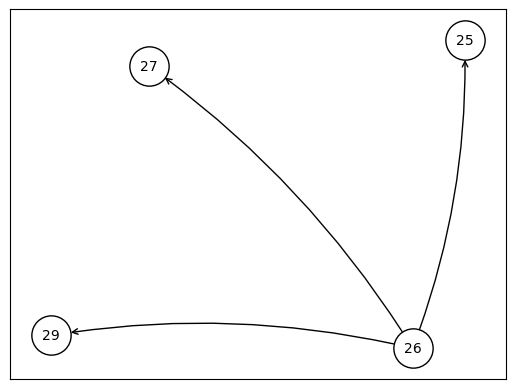

In [23]:
explanation.visualize_graph()